In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

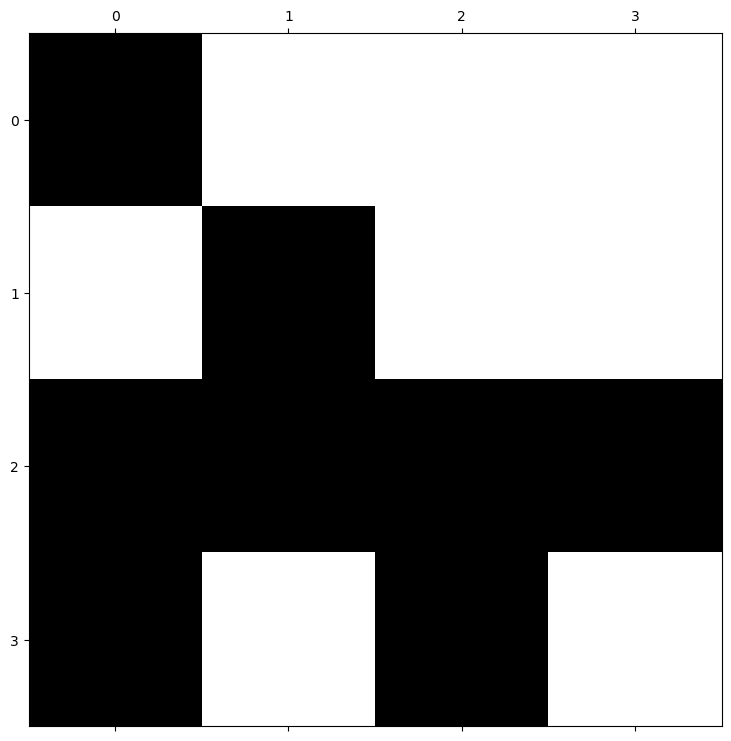

In [112]:
class Node:
    def __init__(self):
        self.rowsWithZero = 0
        self.rank = 0
        self.Ucolumns = None
        self.Vrows = None
        self.eigenvalues = None
        self.children = []
        self.m = 0
        self.n = 0
            

    def draw_matrix(self):
        def build_draw_matrix(node):
            if node.children != []:
                return np.vstack((np.hstack((build_draw_matrix(node.children[0]), build_draw_matrix(node.children[1]))),
                        np.hstack((build_draw_matrix(node.children[2]), build_draw_matrix(node.children[3]))),))
            if node.rank > 0:
                mtrx = np.zeros((node.n, node.m))
                mtrx[:, :node.rank] = 1
                mtrx[:node.rank, :] = 1
                return mtrx
            else:
                return np.zeros((node.n, node.m))
        fig, ax = plt.subplots(figsize=(16, 9))
        ax.matshow(build_draw_matrix(self), cmap=ListedColormap(['w', 'k']))
        plt.show()
        

def compress_matrix(A, epsilon, r):
    '''Matrix compression using the SVD algorithm.'''

    v = Node()

    numRows, numCols = A.shape
    submatrices = [
        A[:numRows//2, :numCols//2],
        A[:numRows//2, numCols//2:],
        A[numRows//2:, :numCols//2],
        A[numRows//2:, numCols//2:],
    ]
    v.m = numRows
    v.n = numCols

    for B in submatrices:
        if np.count_nonzero(B) == 0:
            w = Node()
            w.rowsWithZero = B.shape[0]
            w.rank = 0
            v.children.append(w)
            w.m = numRows//2
            w.n = numCols//2
        else:
            U, D, Vt = np.linalg.svd(B)

            eigenvalues = np.diag(D)
            k = np.sum(D > epsilon)

            if k == 0:
                w = Node()
                w.rowsWithZero = B.shape[0]
                w.rank = 0
                v.children.append(w)
                w.m = numRows//2
                w.n = numCols//2
            elif (k <= r) and ((k < (numRows // 2)) or (k == 1)):
                w = Node()
                w.rank = k
                w.Ucolumns = U[:, :k]
                w.Vrows = Vt[:k, :].transpose()
                w.eigenvalues = eigenvalues[:k, :k]
                w.Vrows = w.Vrows @ w.eigenvalues
                v.children.append(w)
                w.m = numRows//2
                w.n = numCols//2
            else:
                w = compress_matrix(B, epsilon, r)
                v.children.append(w)

    return v


A = np.array([[1, 0, 0, 0], [0, 0.3, 0, 0], [1, 0, 0, 6], [0, 0, 0, 0]])
epsilon = 0.01
r = 2

result = compress_matrix(A, epsilon, r)

result.draw_matrix()

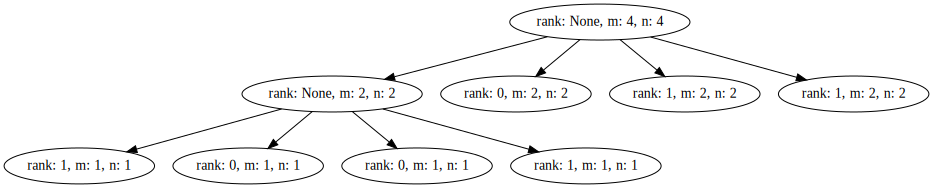

In [38]:
import graphviz
def draw_tree(root):
    ''' Function to draw a tree using graphviz '''
    dot = graphviz.Digraph()

    def traverse(node, parent_id=None):
        node_id = str(id(node))
#         label = f"Rank: {node.rank}\nRows with Zero: {node.rowsWithZero}\nRank is: {node.rank}\nUcolumns: {node.Ucolumns}\nVrows: {node.Vrows}\nEigenvalues: {node.eigenvalues}"

        label = f"rank: {node.rank}, m: {node.m}, n: {node.n}"
        if parent_id is not None:
            dot.edge(parent_id, node_id)

        dot.node(node_id, label)

        for child in node.children:
            traverse(child, node_id)

    traverse(root)
    return dot

draw_tree(result)

In [109]:
def decompress_matrix(node):
    ''' Function to decompress a matrix from a tree'''
    if node.rowsWithZero > 0:
        return np.zeros((node.rowsWithZero, node.rowsWithZero))

    if node.Ucolumns is not None and node.Vrows is not None:
        reconstructed_matrix = np.dot(node.Ucolumns, node.Vrows.transpose())
        return reconstructed_matrix
    else:
        top_left = decompress_matrix(node.children[0])
        top_right = decompress_matrix(node.children[1])
        bottom_left = decompress_matrix(node.children[2])
        bottom_right = decompress_matrix(node.children[3])

        return np.vstack((np.hstack((top_left, top_right)), np.hstack((bottom_left, bottom_right))))

reconstructed_A = decompress_matrix(result)

print("Original Matrix:")
print(A)

print("\nReconstructed Matrix:")
print(reconstructed_A)

Original Matrix:
[[0.07763717 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.4930559  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.58175506 0.        ]
 [0.         0.         0.         ... 0.         0.70151887 0.92990754]]

Reconstructed Matrix:
[[1.  0.  0.  0. ]
 [0.  0.3 0.  0. ]
 [1.  0.  0.  6. ]
 [0.  0.  0.  0. ]]


In [26]:
def test_compression(A, epsilon, r, print_matrices=False):
    ''' Function to test the compression and decompression of a matrix and print nr of differences '''
    result = compress_matrix(A, epsilon, r)
    reconstructed_A = decompress_matrix(result)

    if print_matrices:
        print("Original Matrix:")
        print(A)

        print("\nReconstructed Matrix:")
        print(reconstructed_A)

    nr_of_diffs = np.sum(A-reconstructed_A > epsilon)
    print(f"Number of differences: {nr_of_diffs}")

        

In [27]:
A = np.array([[1, 0.11, 0, 0], [0, 0.3, 0, 0], [1, 0, 0, 6], [0, 0, 0, 1.2]])
epsilon = 0.01
r = 2

test_compression(A, epsilon, r, True)

Original Matrix:
[[1.   0.11 0.   0.  ]
 [0.   0.3  0.   0.  ]
 [1.   0.   0.   6.  ]
 [0.   0.   0.   1.2 ]]

Reconstructed Matrix:
[[1.   0.11 0.   0.  ]
 [0.   0.3  0.   0.  ]
 [1.   0.   0.   6.  ]
 [0.   0.   0.   1.2 ]]
Number of differences: 0


### Tests


In [6]:
def create_matrix_with_zeros(k, percentage_of_zeros):
    ''' Function to create a matrix with a given percentage of zeros '''
    shape = (k, k)

    num_elements = np.prod(shape)

    num_zeros = int(num_elements * percentage_of_zeros)
    num_non_zeros = num_elements - num_zeros

    arr = np.zeros(shape)

    non_zero_indices = np.random.choice(range(num_elements), size=num_non_zeros, replace=False)
    arr[np.unravel_index(non_zero_indices, shape)] = np.random.rand(num_non_zeros)

    return arr



10.66140414144336
(-4.611164724235291-2.920641405927678j)


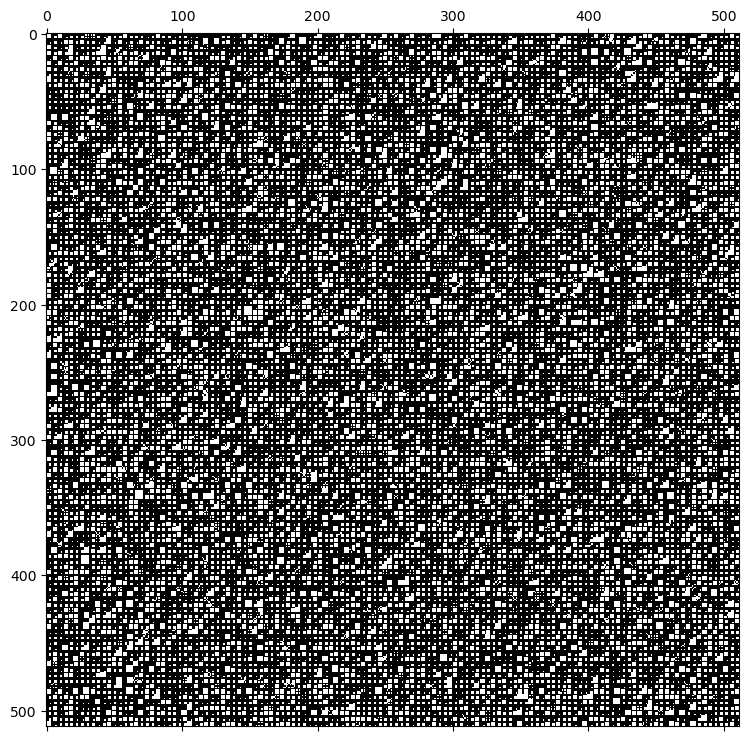

In [77]:
A = create_matrix_with_zeros(k = 2**9,percentage_of_zeros=0.80)
epsilon = 0.000001
r = 2**2
_, S, _ = np.linalg.svd(A)

print(np.linalg.eig(A)[0][2])
nde = compress_matrix(A, S[2**9-1], r)
nde.draw_matrix()


In [110]:
from time import time

def tests(dim, b_values, percentages, s_values):
    for percent in percentages:
        A = create_matrix_with_zeros(k = dim, percentage_of_zeros=percent)
   
        S = np.linalg.svd(A, compute_uv=False)
        plt.plot(S, marker='.', linestyle='-', color='b')
        plt.ylabel('Wartość')
        plt.show()
        for b in b_values:
            for s in s_values:
                start = time()
                root = compress_matrix(A, S[s], b)
                end = time()
                root.draw_matrix()
                square_differences = np.sum((A - decompress_matrix(root)) ** 2)
                print(f"Macierz: {percent}%, b = {b}, s = {s}\n\t Czas: {end-start}s\n\t Różnica: {square_differences}")

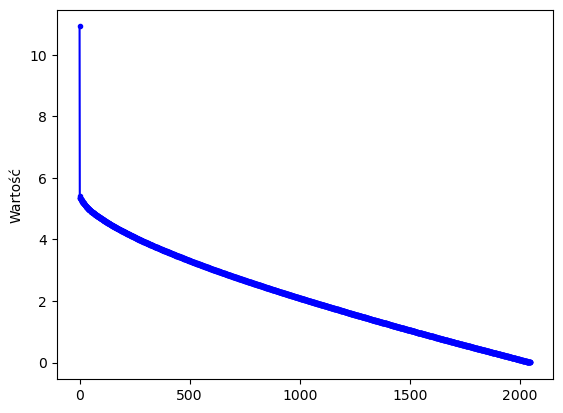

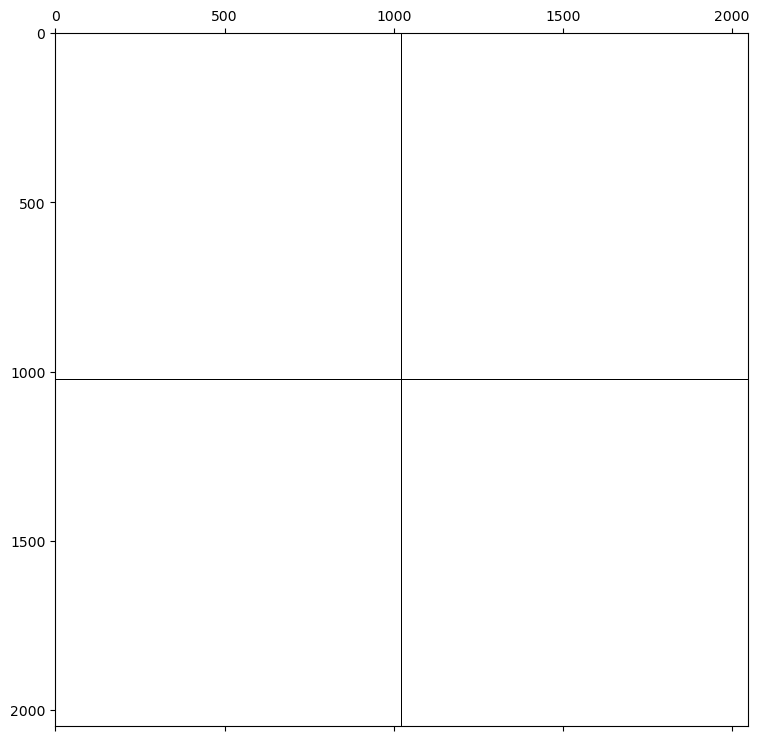

Macierzy 0.99%, b = 1, s = 1
	 Czas: 1.2118902206420898s
	 Różnica: 13785.669651941636


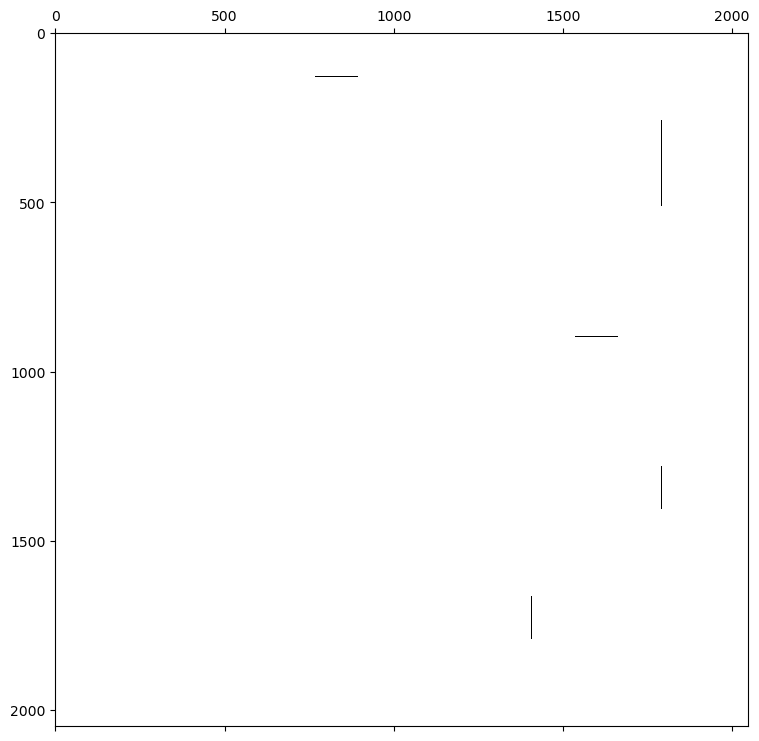

Macierzy 0.99%, b = 1, s = 1024
	 Czas: 2.698157548904419s
	 Różnica: 13864.428402048261


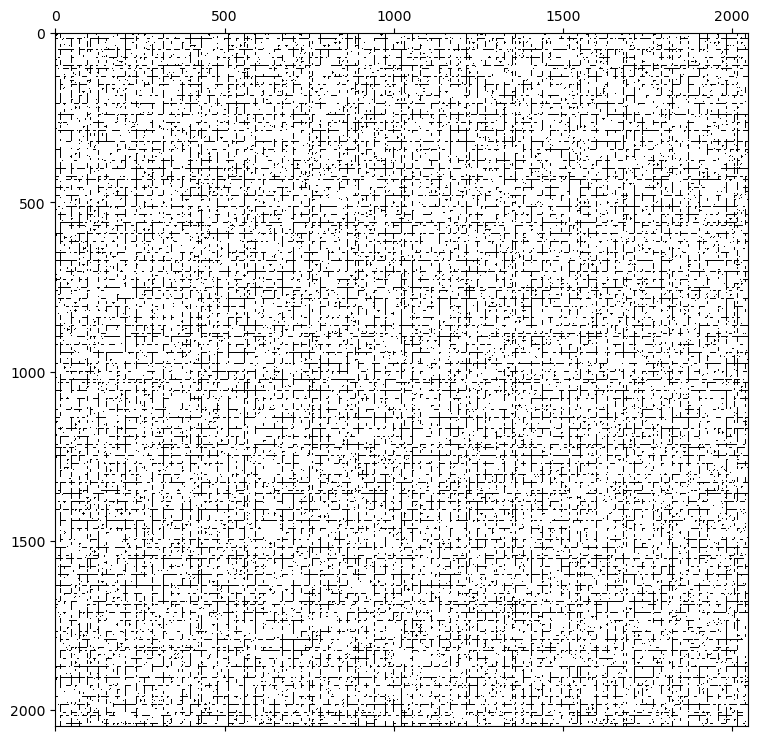

Macierzy 0.99%, b = 1, s = 2047
	 Czas: 5.772250413894653s
	 Różnica: 7.371795501644442e-05


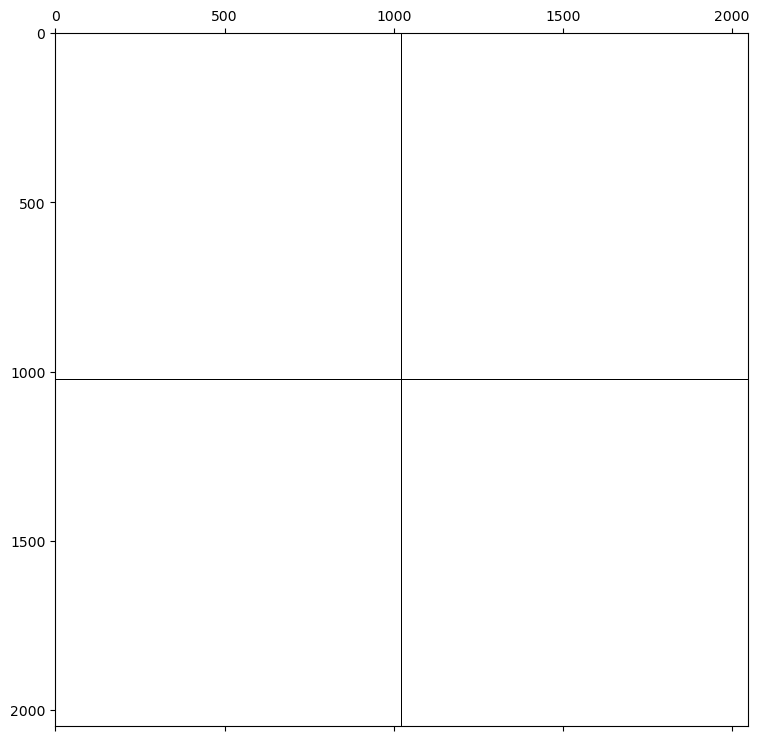

Macierzy 0.99%, b = 4, s = 1
	 Czas: 1.12904691696167s
	 Różnica: 13785.669651941636


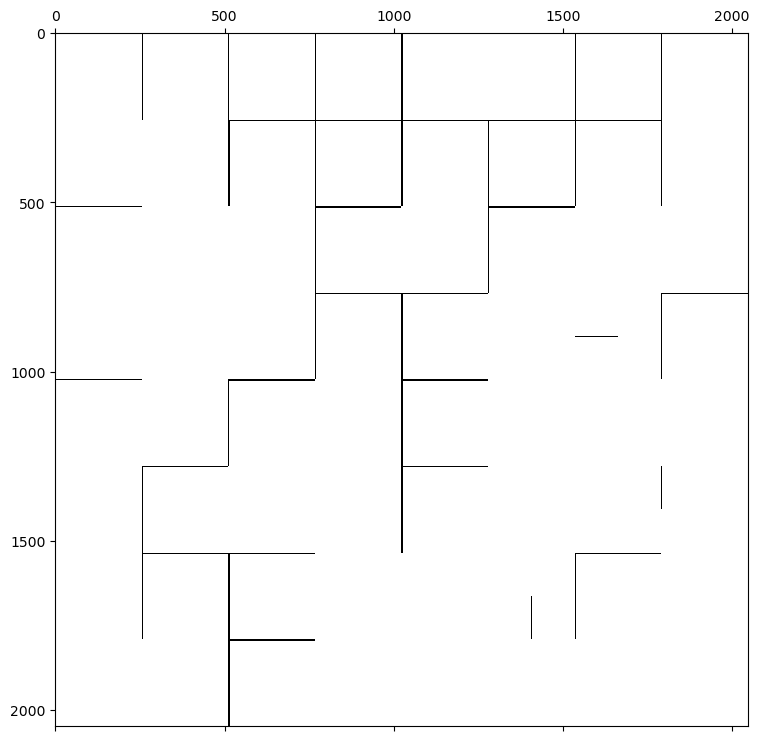

Macierzy 0.99%, b = 4, s = 1024
	 Czas: 2.5937564373016357s
	 Różnica: 13449.410964501349


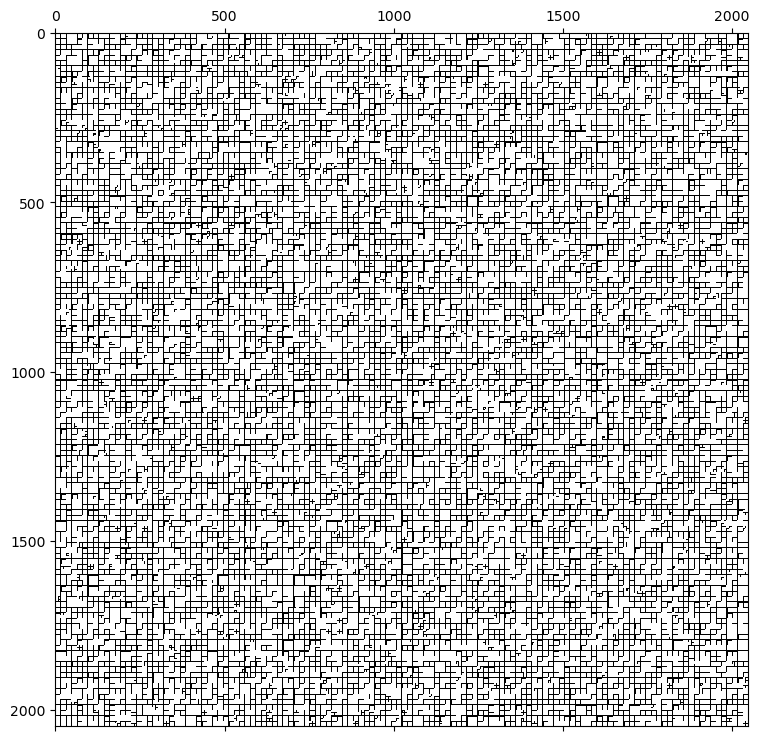

Macierzy 0.99%, b = 4, s = 2047
	 Czas: 4.433039426803589s
	 Różnica: 6.958662089698066e-05


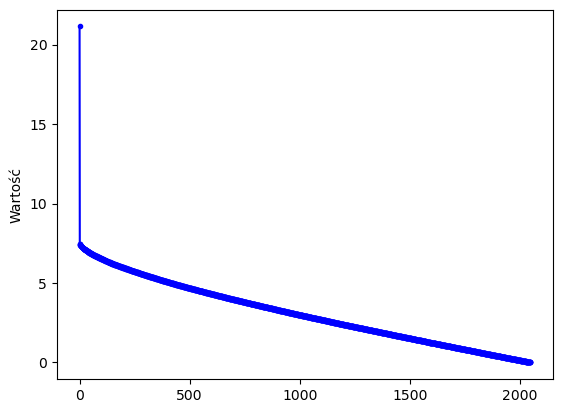

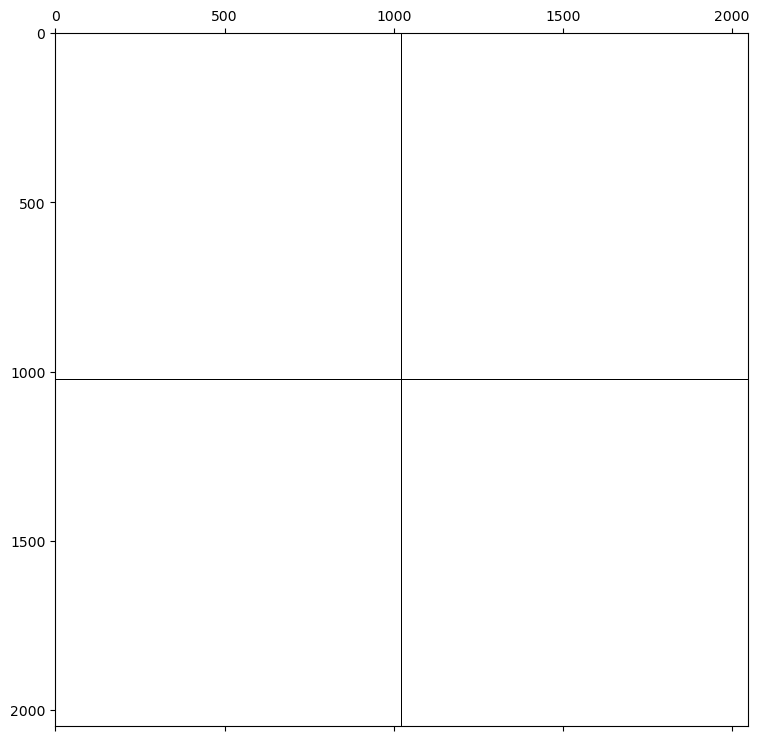

Macierzy 0.98%, b = 1, s = 1
	 Czas: 1.2434487342834473s
	 Różnica: 27446.924732693264


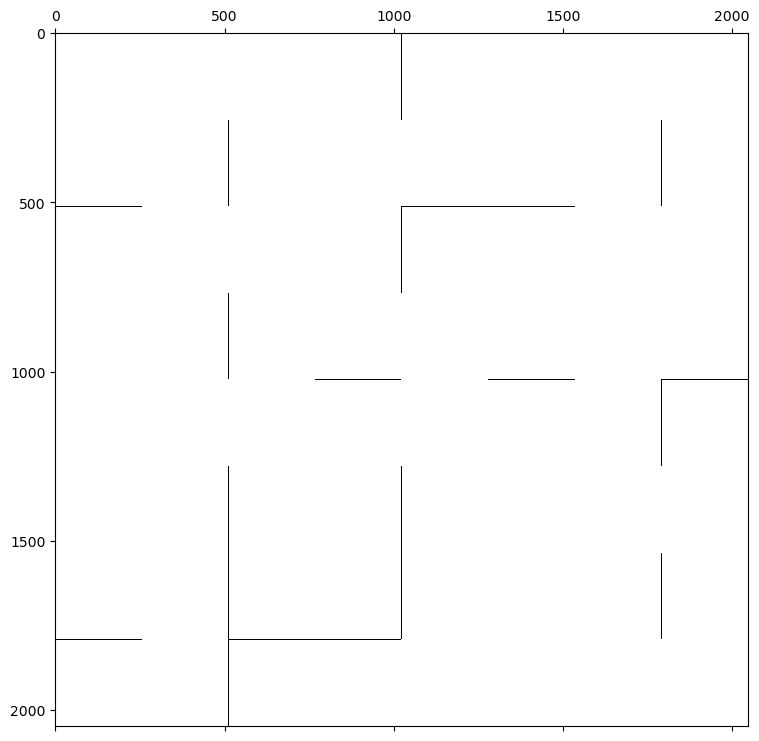

Macierzy 0.98%, b = 1, s = 1024
	 Czas: 2.7772605419158936s
	 Różnica: 27569.018164256544


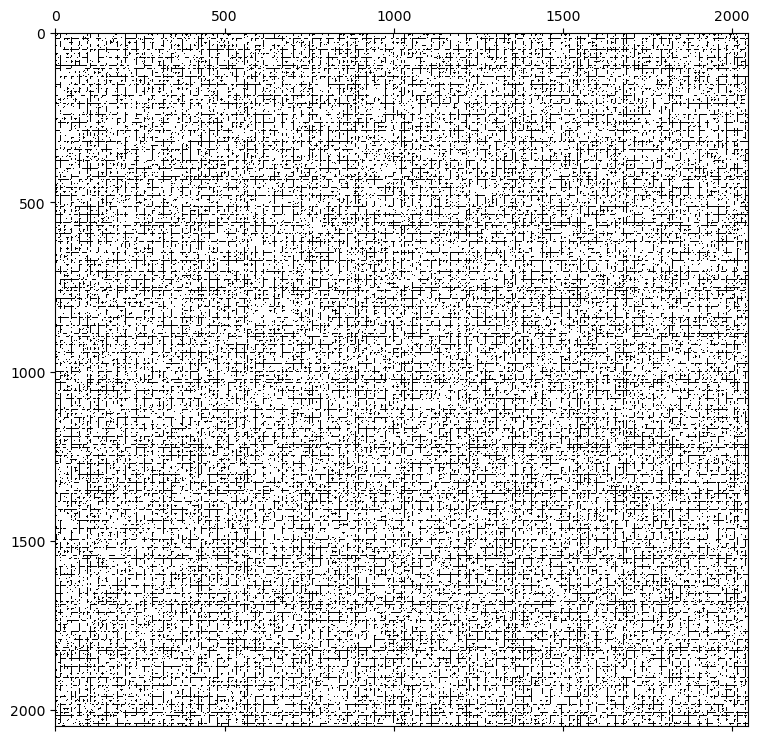

Macierzy 0.98%, b = 1, s = 2047
	 Czas: 9.491250038146973s
	 Różnica: 6.577423785716707e-05


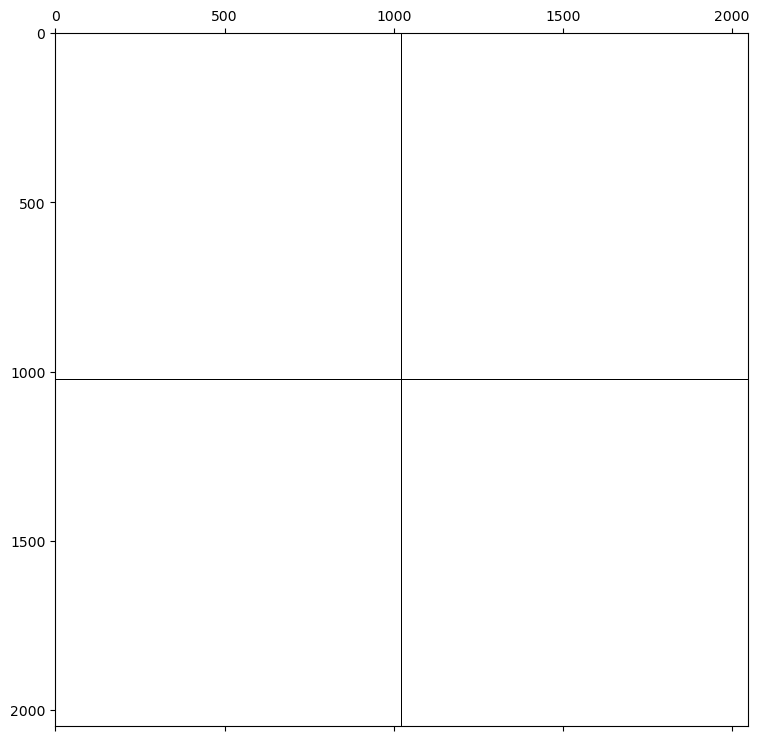

Macierzy 0.98%, b = 4, s = 1
	 Czas: 1.31778883934021s
	 Różnica: 27446.924732693264


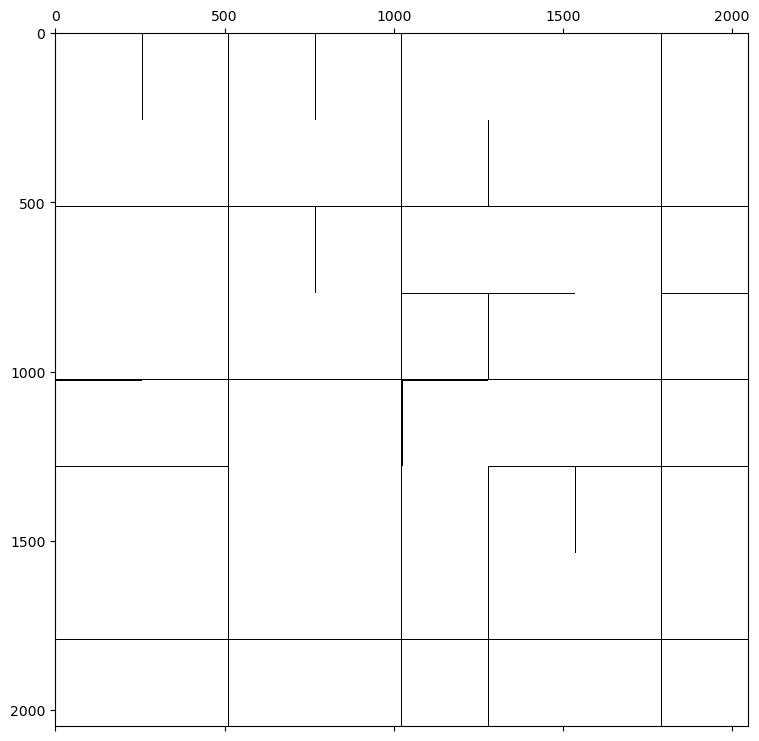

Macierzy 0.98%, b = 4, s = 1024
	 Czas: 2.3846471309661865s
	 Różnica: 26844.57669171384


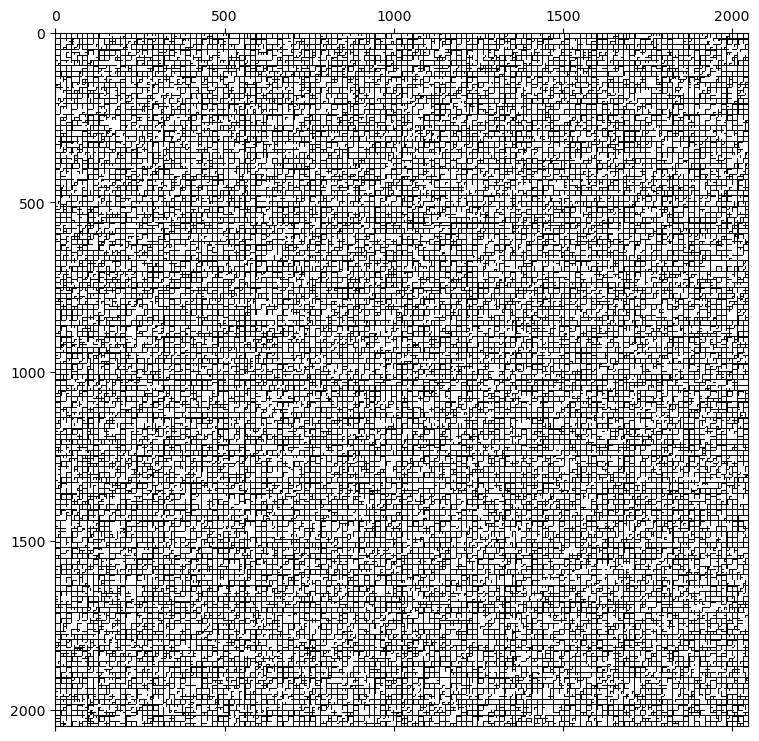

Macierzy 0.98%, b = 4, s = 2047
	 Czas: 5.910624742507935s
	 Różnica: 6.623724628337113e-05


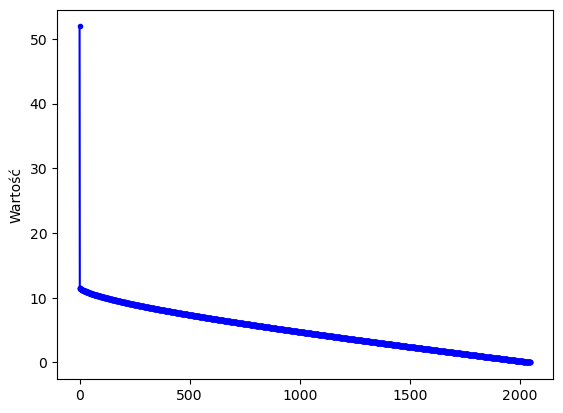

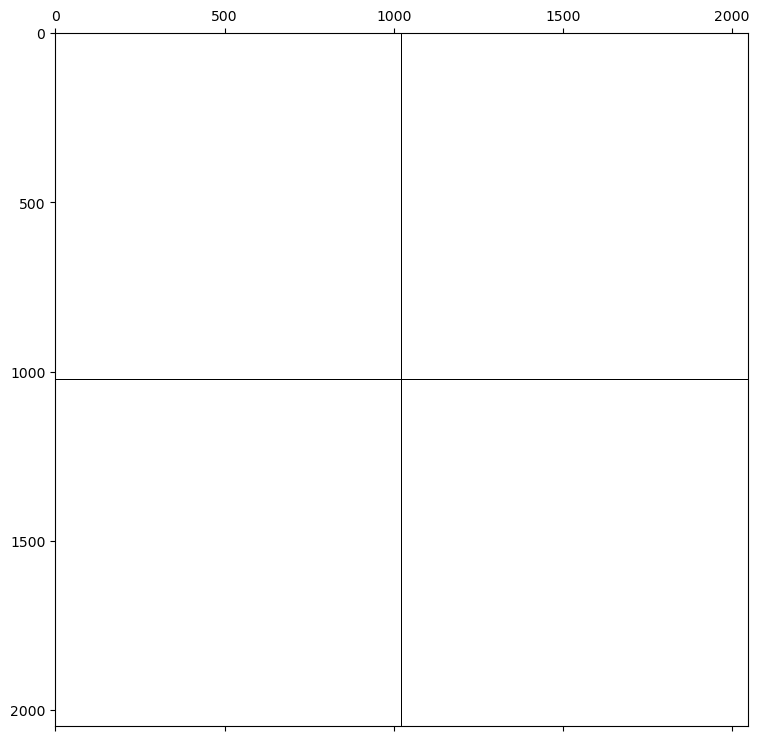

Macierzy 0.95%, b = 1, s = 1
	 Czas: 1.2192940711975098s
	 Różnica: 67327.38902131657


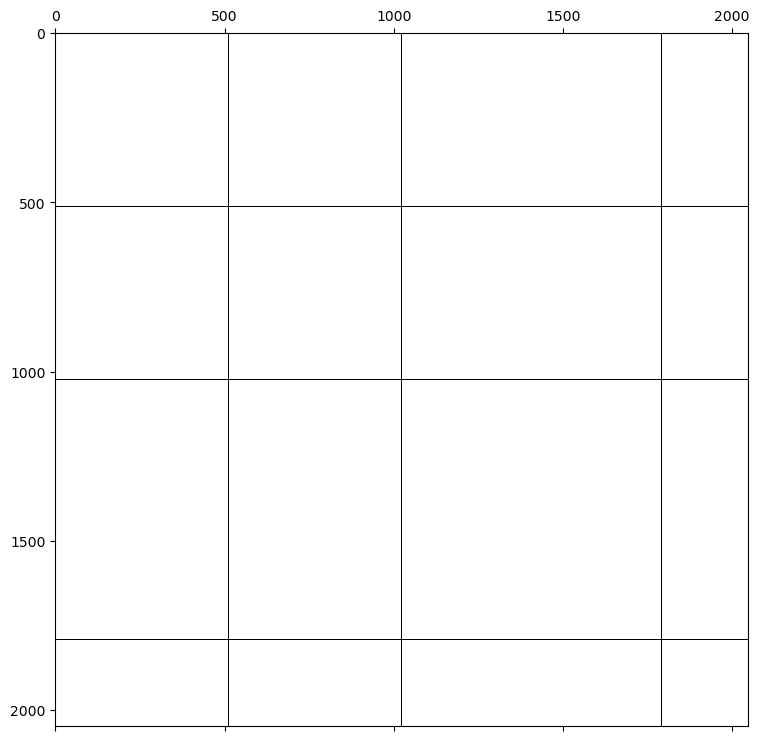

Macierzy 0.95%, b = 1, s = 1024
	 Czas: 2.405719041824341s
	 Różnica: 66843.46492811652


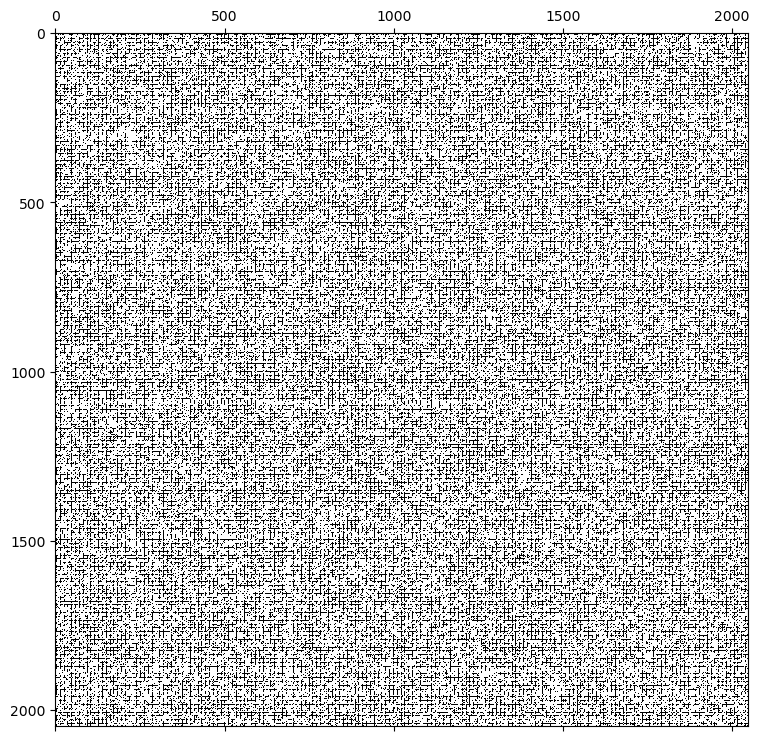

Macierzy 0.95%, b = 1, s = 2047
	 Czas: 15.951759099960327s
	 Różnica: 0.002302519839329716


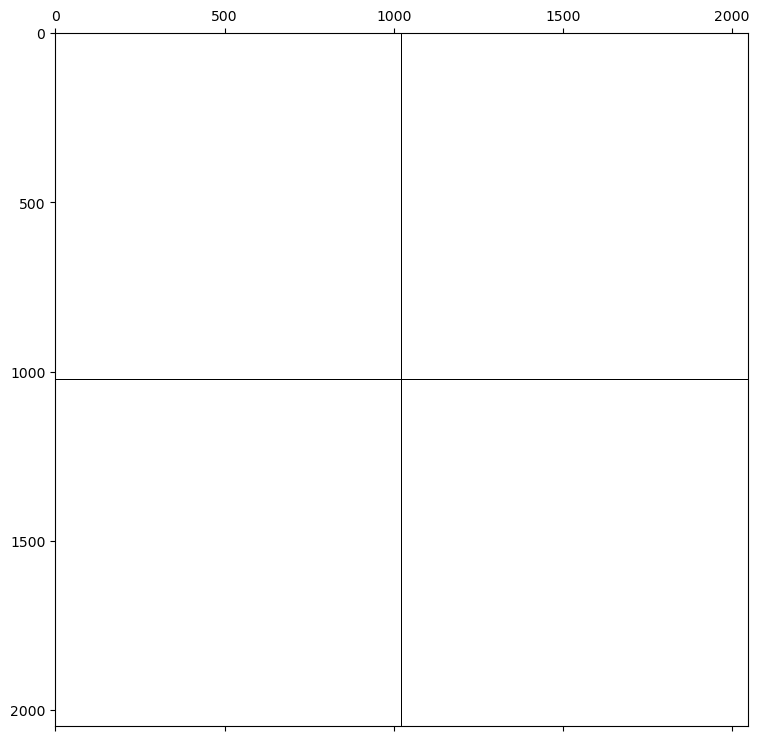

Macierzy 0.95%, b = 4, s = 1
	 Czas: 1.3676340579986572s
	 Różnica: 67327.38902131657


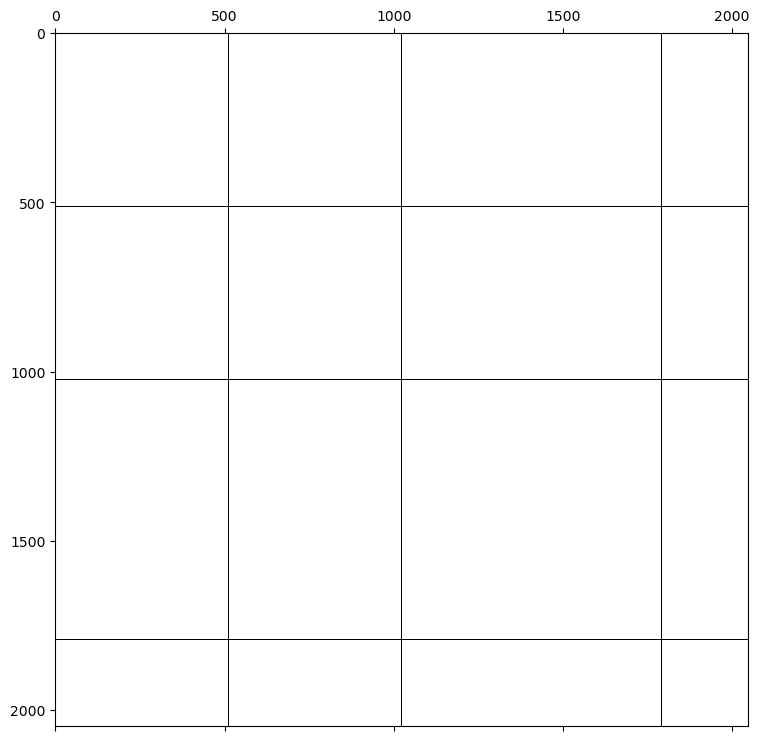

Macierzy 0.95%, b = 4, s = 1024
	 Czas: 2.567000389099121s
	 Różnica: 66843.46492811652


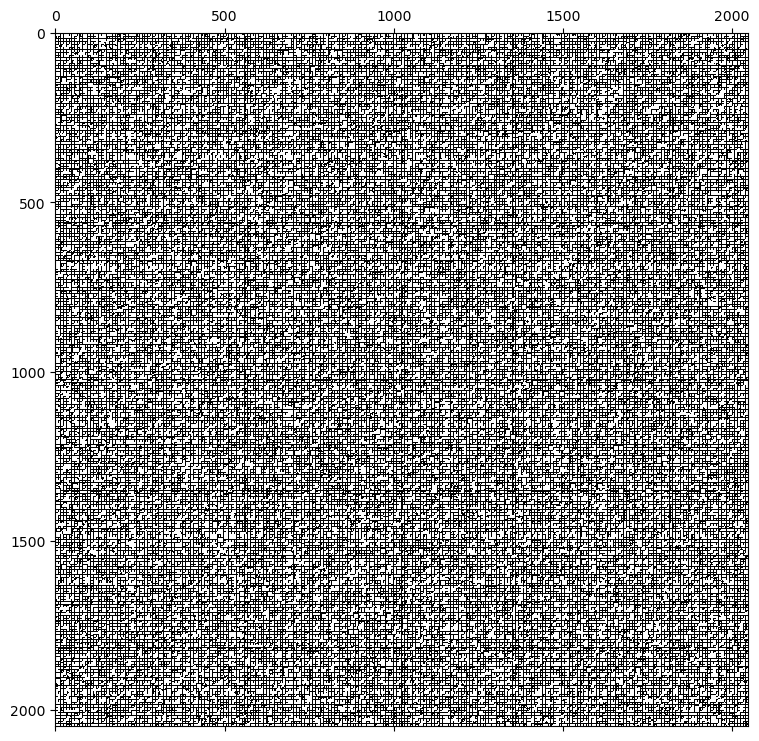

Macierzy 0.95%, b = 4, s = 2047
	 Czas: 8.749656915664673s
	 Różnica: 0.001906877049677968


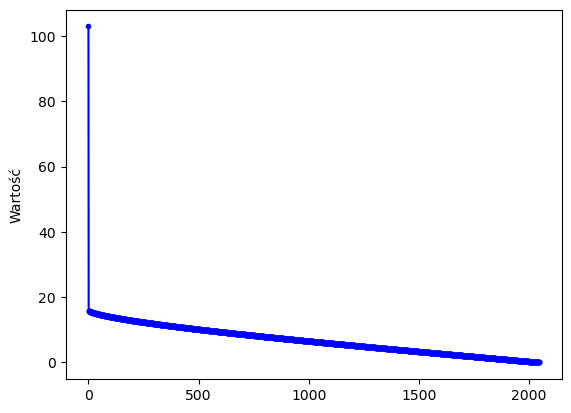

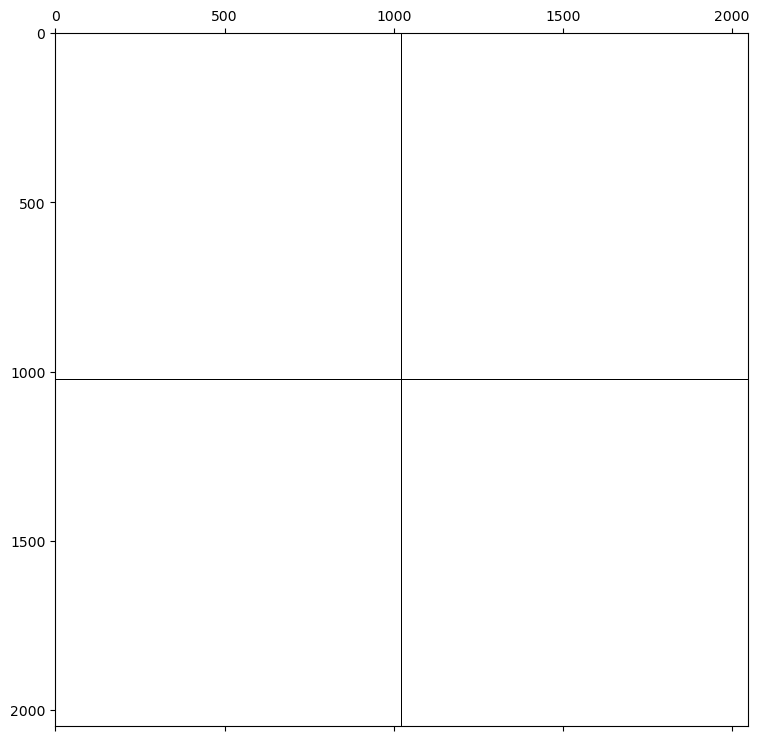

Macierzy 0.9%, b = 1, s = 1
	 Czas: 1.179361343383789s
	 Różnica: 128826.06343941529


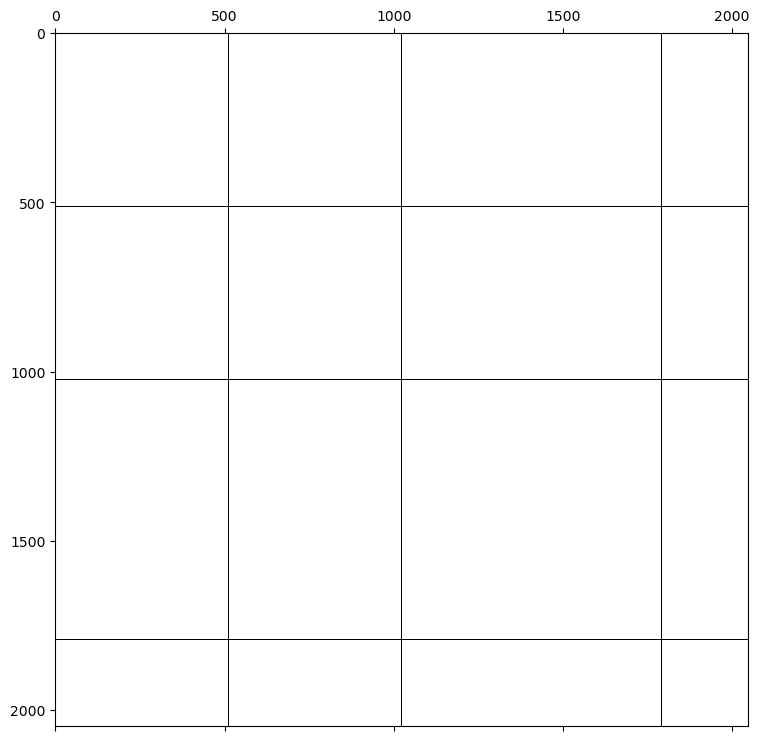

Macierzy 0.9%, b = 1, s = 1024
	 Czas: 2.5284130573272705s
	 Różnica: 128001.32715706454


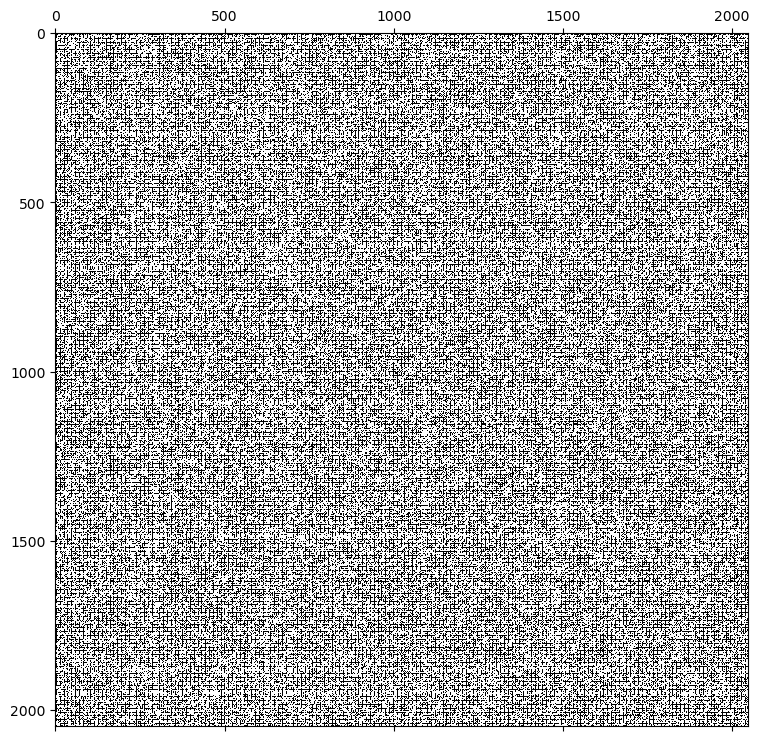

Macierzy 0.9%, b = 1, s = 2047
	 Czas: 28.0433030128479s
	 Różnica: 1.4398412355084302e-06


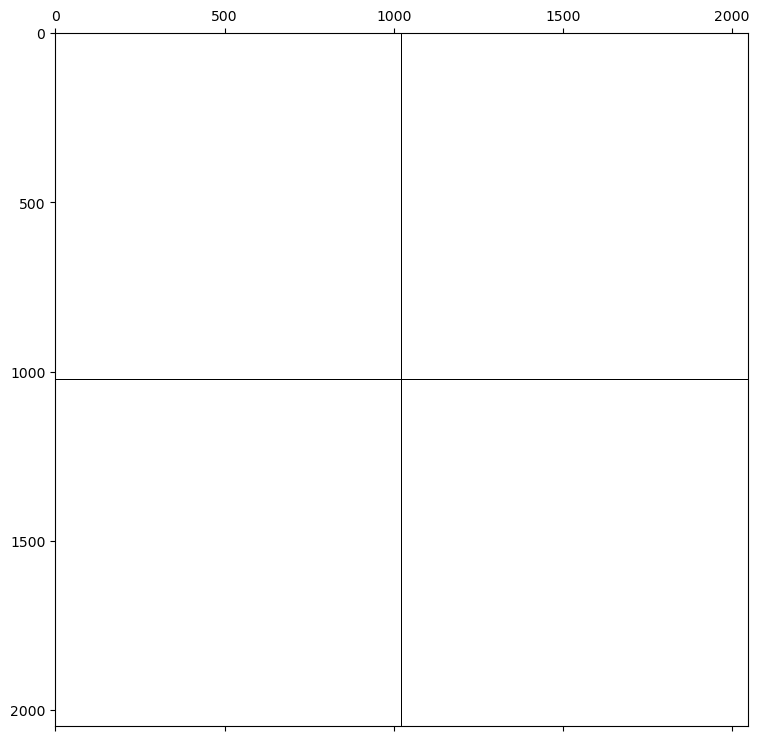

Macierzy 0.9%, b = 4, s = 1
	 Czas: 1.5930392742156982s
	 Różnica: 128826.06343941529


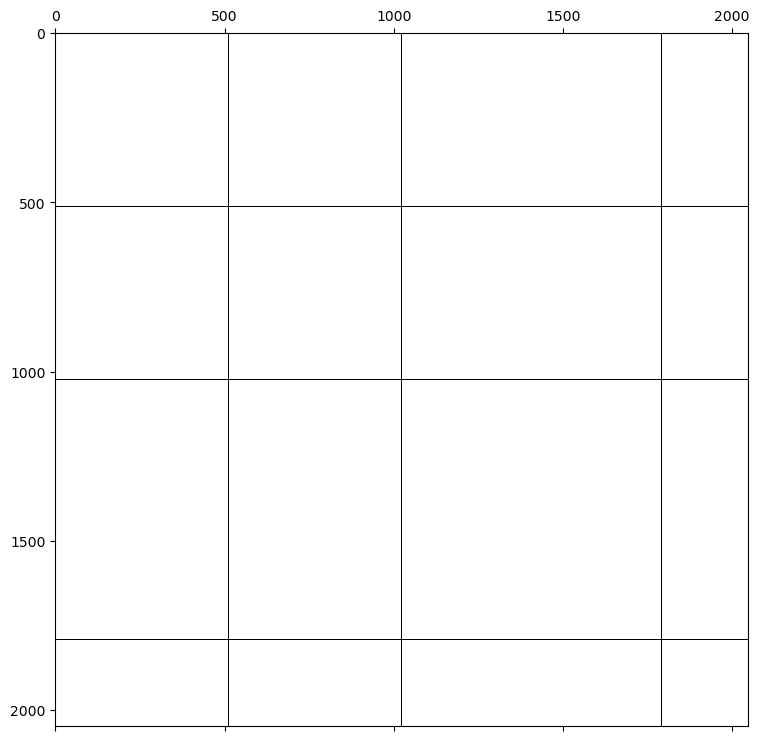

Macierzy 0.9%, b = 4, s = 1024
	 Czas: 2.414003849029541s
	 Różnica: 128001.32715706454


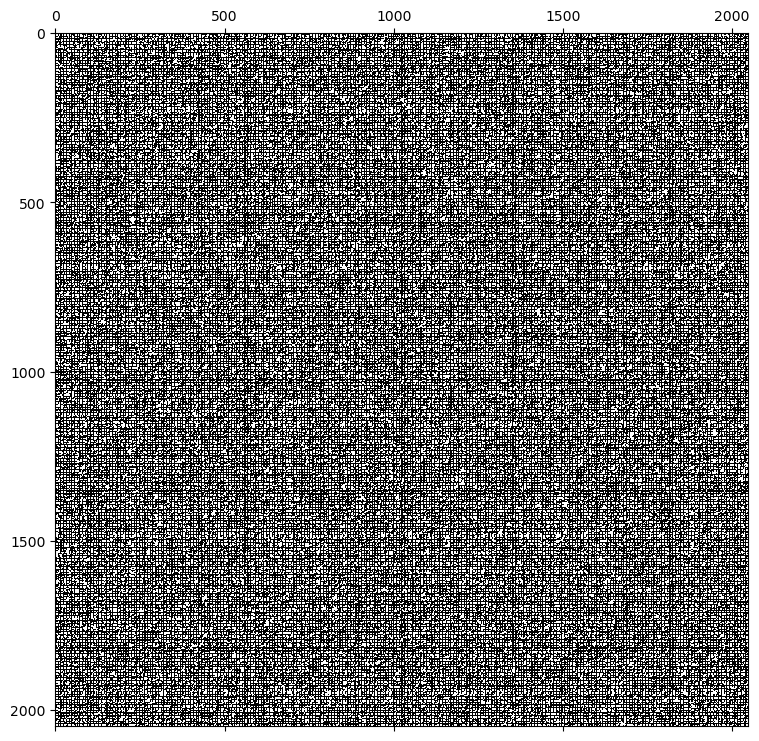

Macierzy 0.9%, b = 4, s = 2047
	 Czas: 11.990119218826294s
	 Różnica: 1.56612168750934e-06


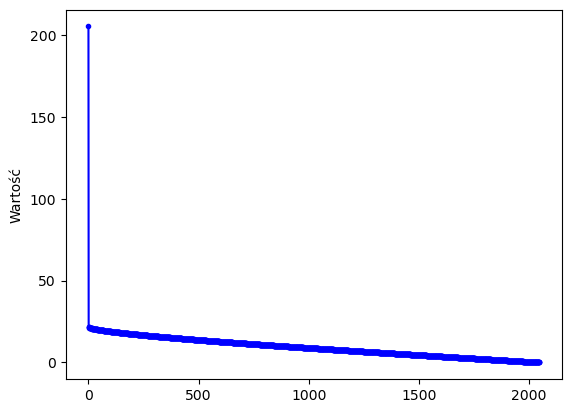

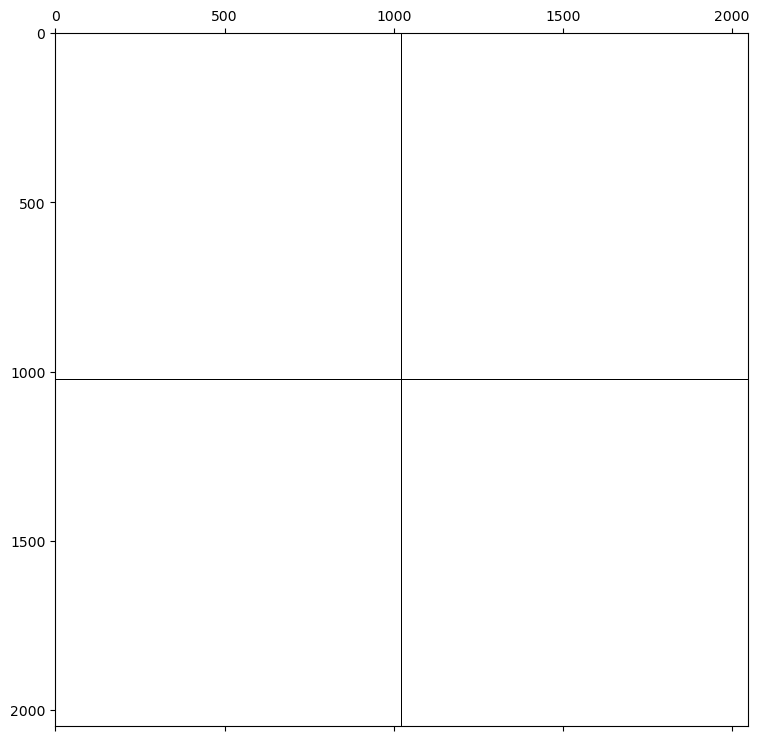

Macierzy 0.8%, b = 1, s = 1
	 Czas: 1.29347825050354s
	 Różnica: 237221.0283160555


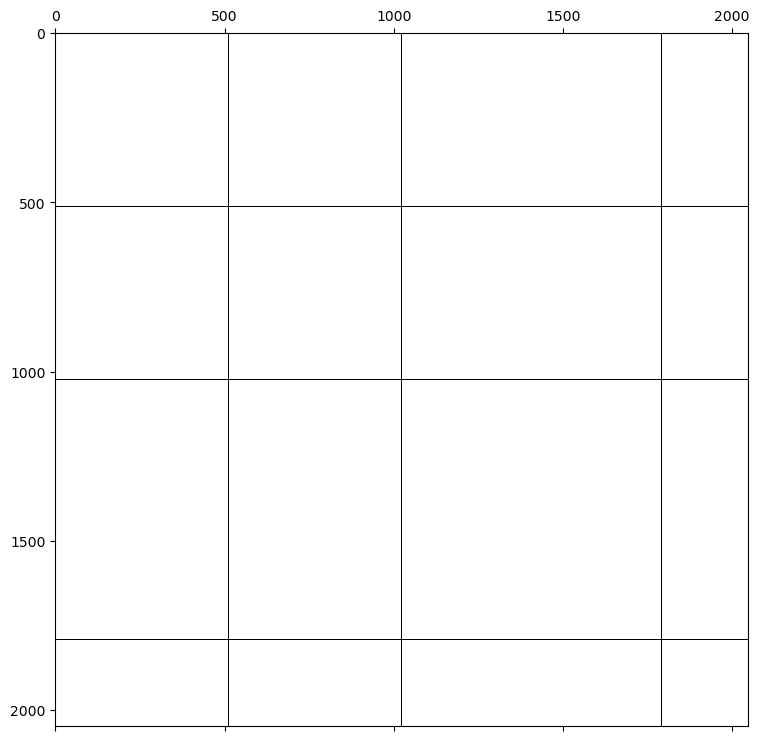

Macierzy 0.8%, b = 1, s = 1024
	 Czas: 2.5251715183258057s
	 Różnica: 235764.16992572247


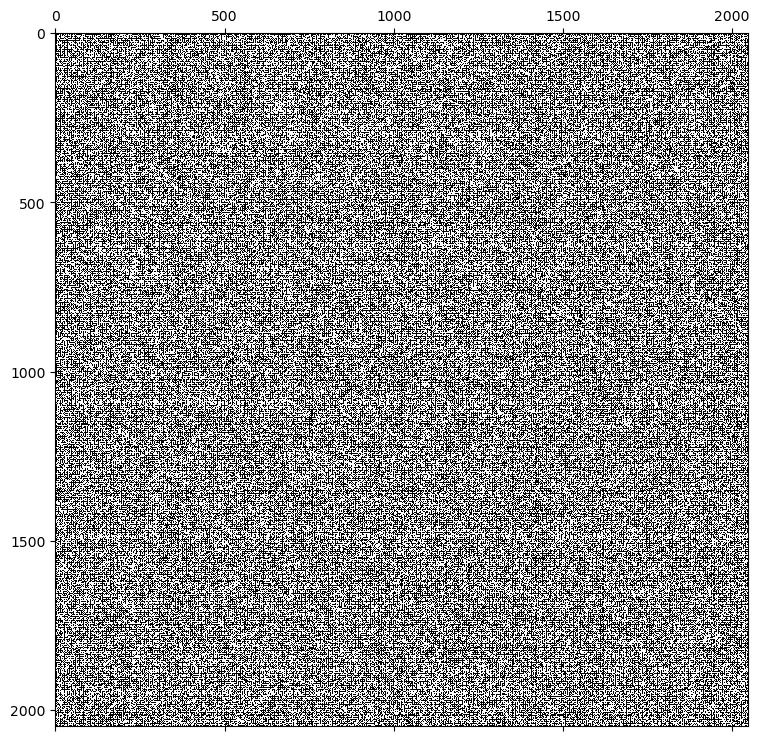

Macierzy 0.8%, b = 1, s = 2047
	 Czas: 48.906272888183594s
	 Różnica: 0.06990752693075404


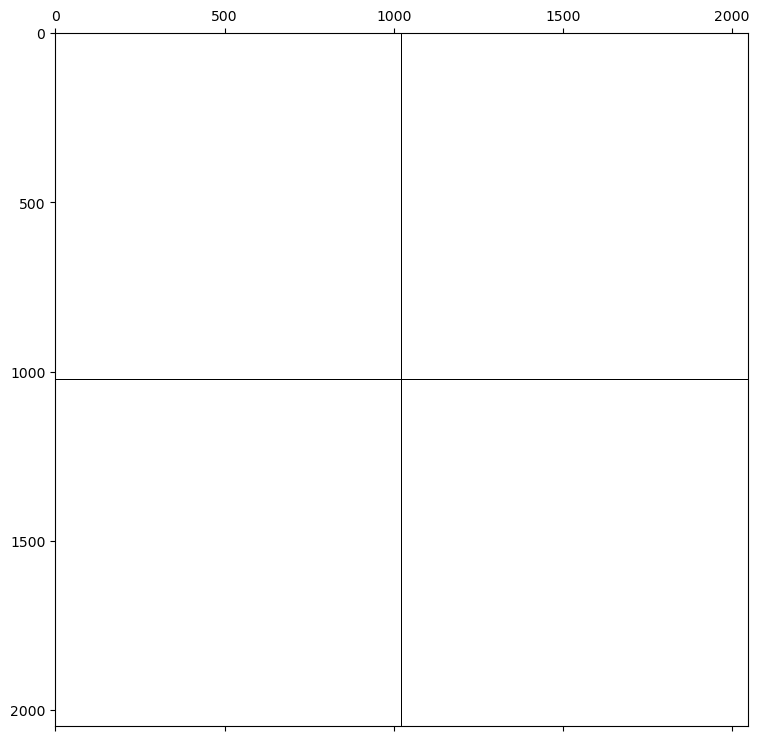

Macierzy 0.8%, b = 4, s = 1
	 Czas: 1.9150266647338867s
	 Różnica: 237221.0283160555


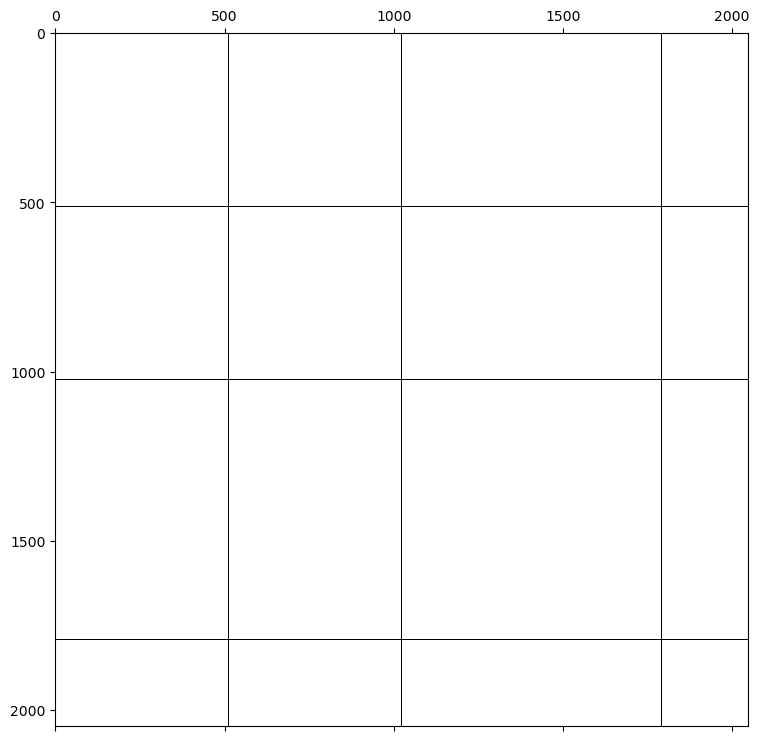

Macierzy 0.8%, b = 4, s = 1024
	 Czas: 2.5081968307495117s
	 Różnica: 235764.16992572247


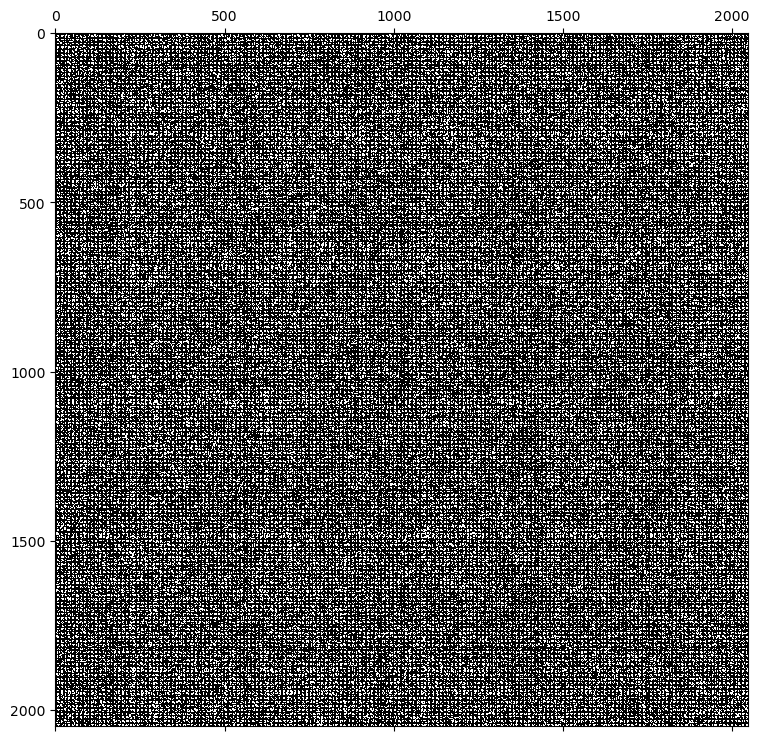

Macierzy 0.8%, b = 4, s = 2047
	 Czas: 19.88004755973816s
	 Różnica: 0.05910623815588073


In [111]:
k = 2**11
tests(k, [1, 4], [0.99, 0.98, 0.95, 0.90, 0.80], [1, k//2, k-1])